In [26]:
!pip3 install sklearn progress iterative-stratification pandas pyss3


In [27]:
from sys import path
import os

# Standard Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, classification_report
# from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
import pyss3
from pyss3 import SS3, VERBOSITY
from pyss3.util import Dataset, Evaluation, span
from pyss3.server import Live_Test
from google.colab import drive

import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt

In [28]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data'
# single_label_dir = '/SB1_Train-entity'

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=59 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=61 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


In [29]:
from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
multi_label_dir_train = '/Muneeb-Entity-Train-Rest'
multi_label_dir_test = '/Muneeb-Entity-Test-Rest'

In [30]:
multi_text_train, multi_labels_train = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_train + '/entity-text.txt',path_root + data_root + multi_label_dir_train + '/entity-labels.txt', sep_label=';')
multi_text_test, multi_labels_test = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_test + '/entity-text.txt',path_root + data_root + multi_label_dir_test + '/entity-labels.txt', sep_label=';')

100%|██████████| 91/91 [00:00<00:00, 31476.30it/s]


In [31]:
del multi_text_train[-1]
del multi_labels_train[-1]
del multi_text_test[-1]
del multi_labels_test[-1]

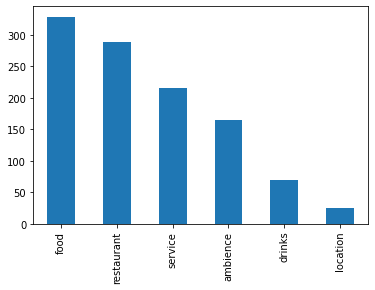

In [32]:
# CLASSES DISTRUBUTION

pd.Series([y for yy in multi_labels_train for y in yy]).value_counts().plot(kind ='bar')

In [33]:
def binarize_categories(cat, multi_labels_train):
  labels = []
  for i, x in enumerate(multi_labels_train):
    try:
      x.index(cat)
      if len(x) == 1:
        labels.append([cat])
      else:
        labels.append([cat, 'others'])
    except ValueError as e:
      labels.append(['others'])
  return labels

def predict(category_classifier,s_val,l_val,p_val,a_val, multi_text_test=multi_text_test):
    result = {}
    for key, value in category_classifier.items():
        value.set_hyperparameters(s=s_val,l=l_val,p=p_val)
        result[key]= value.predict(multi_text_test, def_cat='most-probable') 
    # print(result)
    y_pred = [[] for _ in range(len(multi_text_test))]
    for i in range(len(multi_text_test)):
        temp = []
        for key, value in result.items():
            if value[i]:
                if value[i][0] != 'others':
                    temp.append(value[i][0])
            else:
                temp.append(key)
        y_pred[i] = list(set(temp))
    return y_pred


In [34]:
### one vs rest classifier training ###
pyss3.set_verbosity(1)

categories = list(set([y for yy in multi_labels_train for y in yy]))
category_classifier = {}
for cat in categories:
  modified_labels = binarize_categories(cat, multi_labels_train)
  clf = SS3(name=cat)
  clf.train(multi_text_train, modified_labels, n_grams=5)
  category_classifier[cat] = clf



Training: 100%|██████████| 349/349 [00:00<00:00, 923.89it/s]


In [35]:
### default classifier training ###
clf = SS3()
clf.train(multi_text_train, multi_labels_train, n_grams=5)

Training: 100%|██████████| 349/349 [00:02<00:00, 155.70it/s]


In [36]:
s=[clf.get_s()]  # [0.2 , 0.32, 0.44, 0.56, 0.68, 0.8]
l=[clf.get_l()]   # [0.1 , 0.48, 0.86, 1.24, 1.62, 2]
p=[clf.get_p()]   # [1.75, 1.95, 2.15, 2.35, 2.55, 2.75]
a=[clf.get_a()]

In [37]:
pyss3.set_verbosity(0)
slpa = list(itertools.product(s,l,p,a))
iterations = len(slpa)
divider = 1
current_iteration = 0
last_metric_value = 0
last_metric_value_default = 0
best_binarized_predicted = []
best_binarized_predicted_default = []
binarized_true = binarize_to_matrix(multi_labels_test, categories)


for s,l,p,a in iter(slpa):
    current_iteration += 1
    print('\r',current_iteration, end='')

    y_pred = predict(category_classifier,s,l,p,a)
    binarized_predicted = binarize_to_matrix(y_pred, categories)
    metric_value= eval_multilabel(binarized_true, binarized_predicted, f1_score, **{"average":"macro", "zero_division" : 0})
    ##save and print##
    if(metric_value > last_metric_value):
        best_binarized_predicted = binarized_predicted
        last_metric_value = metric_value
        best = (s,l,p,a)

    clf.set_hyperparameters(s,l,p,a)
    y_pred_default = clf.predict(multi_text_test)
    binarized_predicted_default = binarize_to_matrix(y_pred_default, categories)
    metric_value_default= eval_multilabel(binarized_true, binarized_predicted_default, f1_score, **{"average":"macro", "zero_division" : 0})
    if(metric_value_default > last_metric_value_default):
        best_binarized_predicted_default = binarized_predicted_default
        last_metric_value_default = metric_value_default
        best_default = (s,l,p,a)


    if(current_iteration%divider == 0):
        print(' -> best value so far: ', last_metric_value, ' -> best values: s={}, l={}, p={}, a={}'.format(best[0], best[1], best[2], best[3]), "iterations: ", current_iteration, "/", iterations)
        print(' -> best value so far: ', last_metric_value_default, ' -> best values: s={}, l={}, p={}, a={}'.format(best_default[0], best_default[1], best_default[2], best_default[3]), "iterations: ", current_iteration, "/", iterations)
        print('------------')

 1 -> best value so far:  0.5319928737778636  -> best values: s=0.45, l=0.5, p=1, a=0.0 iterations:  1 / 1
 -> best value so far:  0.519168391994479  -> best values: s=0.45, l=0.5, p=1, a=0.0 iterations:  1 / 1
------------


0.5319928737778636
              precision    recall  f1-score   support

    ambience       0.65      0.54      0.59        37
  restaurant       0.89      1.00      0.94        80
        food       0.97      0.45      0.62        86
      drinks       0.75      0.12      0.21        25
     service       0.72      1.00      0.84        64
    location       0.00      0.00      0.00         9

   micro avg       0.81      0.68      0.74       301
   macro avg       0.66      0.52      0.53       301
weighted avg       0.81      0.68      0.69       301
 samples avg       0.82      0.71      0.73       301



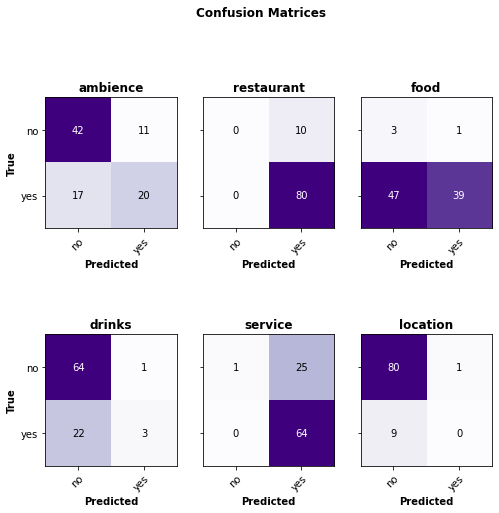

In [38]:
print(f1_score(binarized_true, best_binarized_predicted, average = "macro",zero_division = 0))

cms = multilabel_confusion_matrix(binarized_true, best_binarized_predicted)
print(classification_report(binarized_true, best_binarized_predicted,target_names=categories, zero_division=1))
Evaluation.__plot_confusion_matrices__(cms, categories, multilabel = True)

## **[DEFAULT MULTI LABEL]**


              precision    recall  f1-score   support

        food       1.00      0.34      0.50        86
  restaurant       0.90      0.65      0.75        80
     service       0.79      0.59      0.68        64
      drinks       0.39      0.68      0.49        25
    ambience       0.58      0.19      0.29        37
    location       0.29      0.67      0.40         9

   micro avg       0.70      0.50      0.58       301
   macro avg       0.66      0.52      0.52       301
weighted avg       0.80      0.50      0.58       301
 samples avg       0.72      0.51      0.56       301


 Exact Match Ratio: 0.022
 Hamming Loss: 0.398


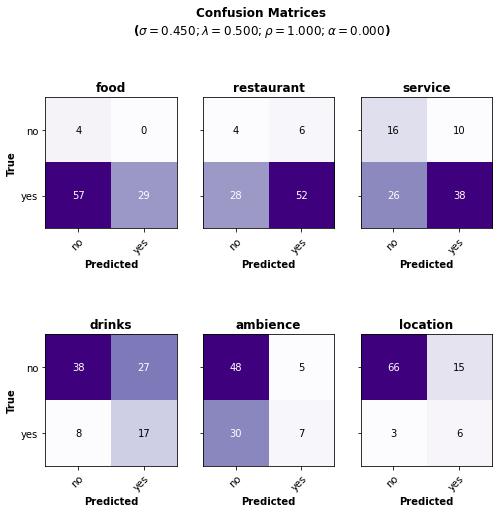

0.39814814814814814

In [39]:
clf.set_hyperparameters(s=best_default[0], l=best_default[1], p=best_default[2], a=best_default[3])
Evaluation.test(clf, multi_text_test, multi_labels_test)